# Direct Shooting vs Direct Transcription

## Notebook Setup 
The following cell will install Drake, checkout the underactuated repository, and set up the path (only if necessary).
- On Google's Colaboratory, this **will take approximately two minutes** on the first time it runs (to provision the machine), but should only need to reinstall once every 12 hours.  Colab will ask you to "Reset all runtimes"; say no to save yourself the reinstall.
- On Binder, the machines should already be provisioned by the time you can run this; it should return (almost) instantly.

More details are available [here](http://underactuated.mit.edu/drake.html).

In [207]:
try:
    import pydrake
    import underactuated
except ImportError:
    !curl -s https://raw.githubusercontent.com/RussTedrake/underactuated/master/scripts/setup/jupyter_setup.py > jupyter_setup.py
    from jupyter_setup import setup_underactuated
    setup_underactuated()

# Setup matplotlib backend (to notebook, if possible, or inline).
from underactuated.jupyter import setup_matplotlib_backend
plt_is_interactive = setup_matplotlib_backend()

In [208]:
# python libraries
import sys
import numpy as np
import scipy as sp
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt

# pydrake imports
from pydrake.all import DiscreteTimeLinearQuadraticRegulator

## Problem Description

In this notebook we compare two approaches to transcribe optimal control problems ([see here for more details](http://underactuated.mit.edu/trajopt.html#computational_considerations)):
- **Direct transcription,** where in the optimal control problem both the inputs $\mathbf{u}[n]$ and the states $\mathbf{x}[n]$ are decision variables, and the dynamic equations $\mathbf{x}[n+1] = \mathbf{f}(\mathbf{x}[n], \mathbf{u}[n])$ are kept as constraints.
- **Direct shooting,** where the states $\mathbf{x}[n]$ are expressed as functions of the initial state $\mathbf{x}[0]$ and the input sequence $(\mathbf{u}[0], \ldots, \mathbf{u}[n-1])$, and eliminated from the optimization problem.

As discussed in the text, in some cases, direct transcription can be numerically more robust and also more efficient, even if direct shooting yields more compact optimization problem (less variables and constraints).
In this notebook we analyze the typical example in which this performance gap appears: optimal control of unstable systems with "long" time horizon.

To make the analysis as simple as possible, we will consider the finite-horizon LQR problem:
\begin{align}
\min & \quad J = \mathbf{x}^T[N] \mathbf{Q}_N \mathbf{x}[N]  + \sum_{n=0}^{N-1} (\mathbf{x}^T[n] \mathbf{Q} \mathbf{x}[n] + \mathbf{u}^T[n] \mathbf{R} \mathbf{u}[n]) \\
\text{subject to} & \quad \mathbf{x}[0] = \mathbf{x}_0, \\
& \quad \mathbf{x}[n+1] = \mathbf{A} \mathbf{x}[n] + \mathbf{B} \mathbf{u}[n]. \\
\end{align}
where $\mathbf{Q}_N \succeq 0$, $\mathbf{Q} \succeq 0$, and $\mathbf{R} \succ 0$.
Of course, numerical optimization is too big of a hammer for this problem: we can solve LQR in almost zero time by working on the Riccati equations!
However, this problem setup is rich enough to exhibit all the characteristic failures that our direct methods might encounter when working with complex robots such as a humanoid.

In this notebook, you'll be asked to work on four pieces of code:
- analyze the conditioning of the linear system of equations we get when using direct shooting,
- implement part of the direct transcription method,
- verify that the cost to go from direct trascription approaches the LQR cost to go as the time horizon grows,
- analyze the conditioning of direct transcription,
- implement the dynamic programming solution (a.k.a. Riccati recursion) for this problem.

Don't worry if you aren't quite sure about the meaning of "conditioning," you'll find all the details below!

## Benchmark System

Just to fix the ideas and plot some results, here we define a dynamical system which we'll use to test the functions we'll write in the notebook.
In particular, we use the discretized and linearized version of the inverted pendulum dynamics.
As we will see, unstable systems clearly highlight the advantages of direct transcription methods.

In [209]:
# time discretization step
h = .5

# linearized continuous time dynamics
# (all physical parameters of the pendulum are set to one)
Act = np.array([[0, 1],[1, 0]])
Bct = np.array([[0],[1]])

# discretize using explicit Euler
# x[n+1] = x[n] + h (Act x[n] + Bct u[n])
#        = (I + h Act) x[n] + h Bct u[n]
A = np.eye(Act.shape[0]) + h * Act
B = h * Bct

# objective function
Q = np.array([[1, 0], [0, 0]])
R = np.array([[1]])
QN = np.array([[3, 0], [0, 2]])

# initial state
x0 = np.array([1, 1])

As an asymptotic comparison for the different optimization problems we'll solve, we use the "closed form" solution of the infinite-horizon discrete-time Riccati equations.
Recall that our LQR problem above has finite time horizon $N$, hence we expect its solution to converge to the infinite-horizon only for long-enough horizons $N$.

In [210]:
# optimal feedback gain and cost-to-go matrix
K, S = DiscreteTimeLinearQuadraticRegulator(A, B, Q, R)

# cost to go from state x0
J_star_inf = x0.dot(S).dot(x0)

## Direct shooting

We start with direct shooting.
[In the lecture notes](http://underactuated.mit.edu/trajopt.html#direct_shooting), we have seen that the state $\mathbf{x}[n]$ can be expressed as a function of the initial state $\mathbf{x}[0]$ and the input sequence $\mathbf{u}[0], \ldots, \mathbf{u}[n-1]$.
We derived the formula
$$\mathbf{x}[n] = \mathbf{A}^n \mathbf{x}_0 + \sum_{k=0}^{n-1} \mathbf{A}^{n-k-1} \mathbf{B} \mathbf{u}[k].$$

Defining the vectors 
$$
\mathbb{x} =
\begin{bmatrix}
\mathbf{x}[1] \\
\vdots \\
\mathbf{x}[N]
\end{bmatrix},
\quad
\mathbb{u} =
\begin{bmatrix}
\mathbf{u}[0] \\
\vdots \\
\mathbf{u}[N-1]
\end{bmatrix},
$$
the formula above can be written in matrix form as
$$
\mathbb{x} =
\begin{bmatrix}
\mathbf{A} \\
\vdots \\
\mathbf{A}^N
\end{bmatrix}
\mathbf{x}_0 +
\begin{bmatrix}
\mathbf{B} & 0 & \cdots & 0 \\
\mathbf{A B} & \mathbf{B} & \cdots & 0 \\
\vdots & \vdots & \ddots  & \vdots \\
\mathbf{A}^{N-1} \mathbf{B} & \mathbf{A}^{N-2} \mathbf{B} & \cdots & \mathbf{B} \\
\end{bmatrix}
\mathbb{u}.
$$
Let us call these two matrices $\mathbb{A}$ and $\mathbb{B}$ (in this notebook we'll use $\mathbb{blackboard \ bold}$ letters for block matrices), so that $\mathbb{x} = \mathbb{A} \mathbf{x}_0 + \mathbb{B} \mathbb{u}$.

In the following cell we provide two efficient functions to construct $\mathbb{A}$ and $\mathbb{B}$.
In the code we denote, e.g., the matrix $\mathbb{A}$ as `Ab`, where `b` stands for block matrix.

In [211]:
# efficient computation of the matrix Ab
def get_Ab(A, N):
    
    # Ab is defined only for N >= 1
    assert N >= 1
    
    # number of states
    p = A.shape[0]
    
    # initialize matrix with all zeros
    Ab = np.zeros((p * N, p))
    
    # put A matrix in top block
    rows = slice(0, p) # equivalent to :p
    Ab[rows, :] = A
    
    # loop over the block-rows
    for n in range(1, N):
        
        # move the row indices one block down
        prev_rows = rows
        rows = slice(prev_rows.start + p, prev_rows.stop + p) # equivalent to n*p:(n+1)*p
        
        # premultiply previous block by A
        # place the result in this block
        Ab[rows, :] = A.dot(Ab[prev_rows, :])
        
    return Ab

# efficient computation of the matrix Bb
def get_Bb(A, B, N):
    
    # Bb is defined only for N >= 1
    assert N >= 1
    
    # number of states and inputs
    p, q = B.shape
    
    # initialize matrix with all zeros
    Bb = np.zeros((p * N, q * N))
    
    # put B matrix in top-left block
    rows = slice(0, p) # equivalent to :p
    Bb[rows, :q] = B
    
    # loop over the block-rows
    for n in range(1, N):
        
        # move the row indices one block down
        prev_rows = rows
        rows = slice(prev_rows.start + p, prev_rows.stop + p) # equivalent to n*p:(n+1)*p
        
        # premultiply first block from previous block-row by A
        # place the result as first block of this block-row
        Bb[rows, :q] = A.dot(Bb[prev_rows, :q])
        
        # shift the rest of previous block-row one block forward and
        # place it in the current block-row
        Bb[rows, q:(n+1)*q] = Bb[prev_rows, :n*q]
        
    return Bb

Let us write the LQR objective function in block-matrix form:
$$
J =
\mathbf{x}_0^T \mathbf{Q} \mathbf{x}_0 +
\mathbb{x}^T
\begin{bmatrix}
\mathbf{Q} & \cdots & 0 & 0 \\
\vdots & \ddots & \vdots & \vdots \\
0 & \cdots  & \mathbf{Q} & 0 \\
0 & \cdots  & 0 & \mathbf{Q}_N \\
\end{bmatrix}
\mathbb{x} +
\mathbb{u}^T
\begin{bmatrix}
\mathbf{R} & \cdots & 0 \\
\vdots & \ddots  & \vdots \\
0 & \cdots  & \mathbf{R}\\
\end{bmatrix}
\mathbb{u}.
$$
We denote the two block-diagonal matrices in the latter equation as $\mathbb{Q}$ and $\mathbb{R}$, so that $J = \mathbf{x}_0^T \mathbf{Q} \mathbf{x}_0 + \mathbb{x}^T \mathbb{Q} \mathbb{x} + \mathbb{u}^T \mathbb{R} \mathbb{u}$.

We now use the relation $\mathbb{x} = \mathbb{A} \mathbf{x}_0 + \mathbb{B} \mathbb{u}$.
After a simple manipulation, we get
$$
J = \mathbf{x}_0^T (\mathbf{Q} + \mathbb{A}^T \mathbb{Q} \mathbb{A}) \mathbf{x}_0 +
2 \mathbf{x}_0^T \mathbb{A}^T \mathbb{Q} \mathbb{B} \mathbb{u} +
\mathbb{u}^T (\mathbb{R} + \mathbb{B}^T \mathbb{Q} \mathbb{B}) \mathbb{u}.
$$
Where we used the fact that the matrices $\mathbf{Q}$, $\mathbf{R}$, and $\mathbf{Q}_N$ are symmetric (hence, so are $\mathbb{Q}$ and $\mathbb{R}$).

The finite-time LQR problem has now become an unconstrained quadratic minimization problem.
To find the optimal control sequence $\mathbb{u}^*$, we just set the derivative of $J$ with respect to $\mathbb{u}$ to zero, and solve the resulting linear system.
We get
$$
2 \mathbb{B}^T \mathbb{Q} \mathbb{A} \mathbf{x}_0 +
2 (\mathbb{R} + \mathbb{B}^T \mathbb{Q} \mathbb{B}) \mathbb{u}
= 0.
$$
Let use define $\mathbb{H} = \mathbb{R} + \mathbb{B}^T \mathbb{Q} \mathbb{B}$.
Note that this matrix is positive definite (hence invertible), since $\mathbb{R} \succ 0$ and $\mathbb{B}^T \mathbb{Q} \mathbb{B} \succeq 0$.
The optimal control sequence is then
$$ \mathbb{u}^* = - \mathbb{H}^{-1} \mathbb{B}^T \mathbb{Q} \mathbb{A} \mathbf{x}_0.$$
The optimal cost $J^*$ can be derived by plugging the controls $\mathbb{u}^*$ in the expression of $J$.

In the following cell we implemented these steps for you.

In [212]:
# function that given the system state x0 (together with:
# the dynamical system matrices A, B; the objective weights
# Q, R, QN; and the controller horizon N) returns the cost
# to go of the finite-horizon LQR using direct shooting
def get_J_star_N_shooting(A, B, Q, R, QN, N, x0):
    
    # condensed dynamic equations
    Ab = get_Ab(A, N)
    Bb = get_Bb(A, B, N)
    
    # weight block matrices
    Qb = sp.linalg.block_diag(*([Q] * (N - 1) + [QN]))
    Rb = sp.linalg.block_diag(*([R] * N))
    Hb = Rb + Bb.T.dot(Qb).dot(Bb)
    
    # solve for the optimal ub
    ub = np.linalg.solve(Hb, - Bb.T.dot(Qb).dot(Ab).dot(x0))
    
    # plug optimal Ub in J to get the cost to go
    J = x0.dot(Q + Ab.T.dot(Qb).dot(Ab)).dot(x0) + \
        2 * x0.dot(Ab.T).dot(Qb).dot(Bb).dot(ub) + \
        ub.dot(Hb).dot(ub)
    
    return J

We can now plot the cost to go of the finite-horizon LQR problem as a function of the horizon $N$, and compare it with the infinite-horizon cost to go.

<IPython.core.display.Javascript object>


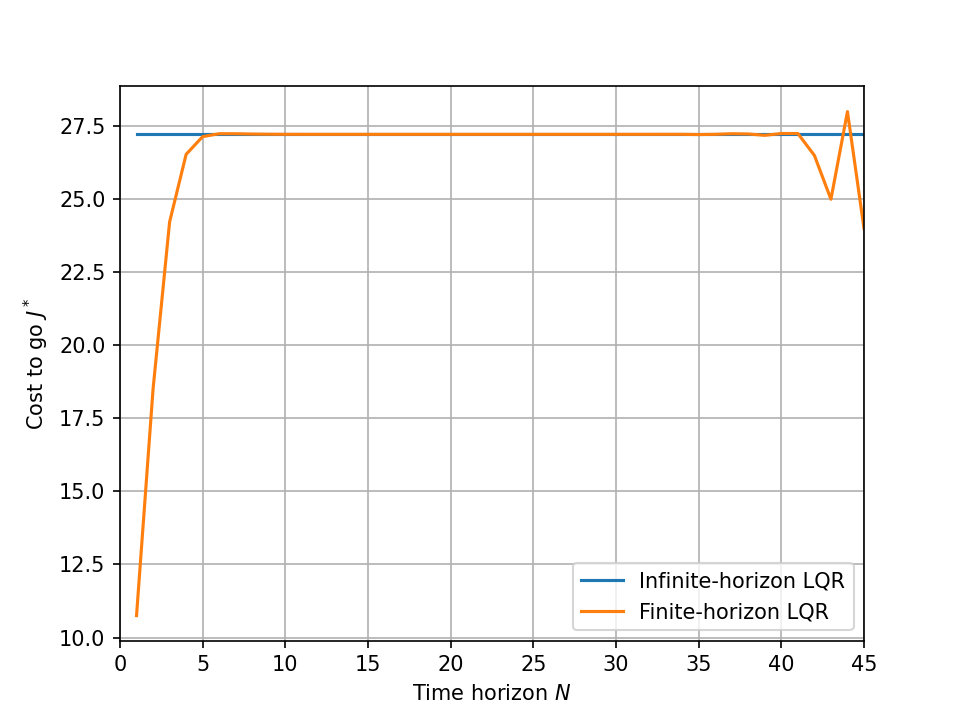

In [213]:
# function that plots the finite-horizon cost to go
# as a function of the horizon length N
# and compares it to the infinite-horizon solution
# J_star_N is a list of floats: cost to go from N = 1 to N = N_max
# J_star_inf is a float: infinite-horizon cost to go
def plot_J_star(J_star_N, J_star_inf):
    
    # maximum length of the horizon
    N_max = len(J_star_N)
    
    # infinite-horizon cost to go
    plt.plot(range(1, N_max + 1), [J_star_inf] * N_max, label='Infinite-horizon LQR')
    
    # finite-horizon cost to go 
    plt.plot(range(1, N_max + 1), J_star_N, label='Finite-horizon LQR')
    
    # misc settings
    plt.xlim(0, N_max)
    plt.xlabel(r'Time horizon $N$')
    plt.ylabel(r'Cost to go $J^*$')
    plt.grid(True)
    plt.legend()
    
# get cost to go as a function of N
N_max = 45
J_star_N_shooting = [get_J_star_N_shooting(A, B, Q, R, QN, N, x0) for N in range(1, N_max + 1)]

# plot finite horizon vs infinite horizon
plt.figure()
plot_J_star(J_star_N_shooting, J_star_inf)

The finite horizon solution already converges to the infinite-horizon one when $N$ is approximately equal to 5.
But when $N$ gets too large, the direct shooting approach runs into troubles!

To understand the reason for this behavior we analyze the [condition number](https://mathworld.wolfram.com/ConditionNumber.html) of $\mathbb{H}$.
For a matrix $A$ the condition number $\text{cond}(A)$ is defined as the ratio between the largest and the smallest singular values.
When solving a linear system $Ax = b$, the larger the condition number, the more sensitive is the solution $x = A^{-1} b$ to small perturbations of the vector $b$.
Hence, if $\text{cond}(A)$ is large, tiny numeric roundings in $b$ can be hugely amplified when solving for $x$.

Another interesting interpretation is the following. The quantity
$$
\log_2 (\text{cond}(A))
$$
is an estimate of how many bits are lost in solving a linear system $Ax = b$.
For example, if $\text{cond}(A) = 2^{10}$ and $b$ is encoded in 64 bits, solving for $x$ we loose 10 of the 64 bits our machine is using!

To get the optimal controls via direct shooting, we invert the matrix $\mathbb{H}$.
In the following cell, you are asked to analyze the condition number of $\mathbb{H}$ as a function of the horizon length $N$.
More specifically, you must set the variable `lost_bits_shooting` to be a list with `N_max = 45` elements.
For `N` ranging from `1` to `N_max`, the `N`th entry in `lost_bits_shooting` must be logarithm in base 2 of the condition number of $\mathbb{H}$ (`Hb` in the code) for a time horizon equal to `N`.

P.s.: you might find the function [`numpy.linalg.cond`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.cond.html) useful here!

In [214]:
# number of bits lost in the inversion of Hb
# as a function of the time horizon N
def get_Hb(N):
    # condensed dynamic equations
    Ab = get_Ab(A, N)
    Bb = get_Bb(A, B, N)
    
    # weight block matrices
    Qb = sp.linalg.block_diag(*([Q] * (N - 1) + [QN]))
    Rb = sp.linalg.block_diag(*([R] * N))
    Hb = Rb + Bb.T.dot(Qb).dot(Bb)
    return Hb

lost_bits_shooting = [np.log2(np.linalg.cond(get_Hb(N))) for N in range(1, N_max + 1)] # modify here

In the following cell we wrote a function to plot your results.
Do you see anything alarming?
Which kind of law does this curve follow: constant, logarithmic, linear, polynomial, or exponential?

<IPython.core.display.Javascript object>


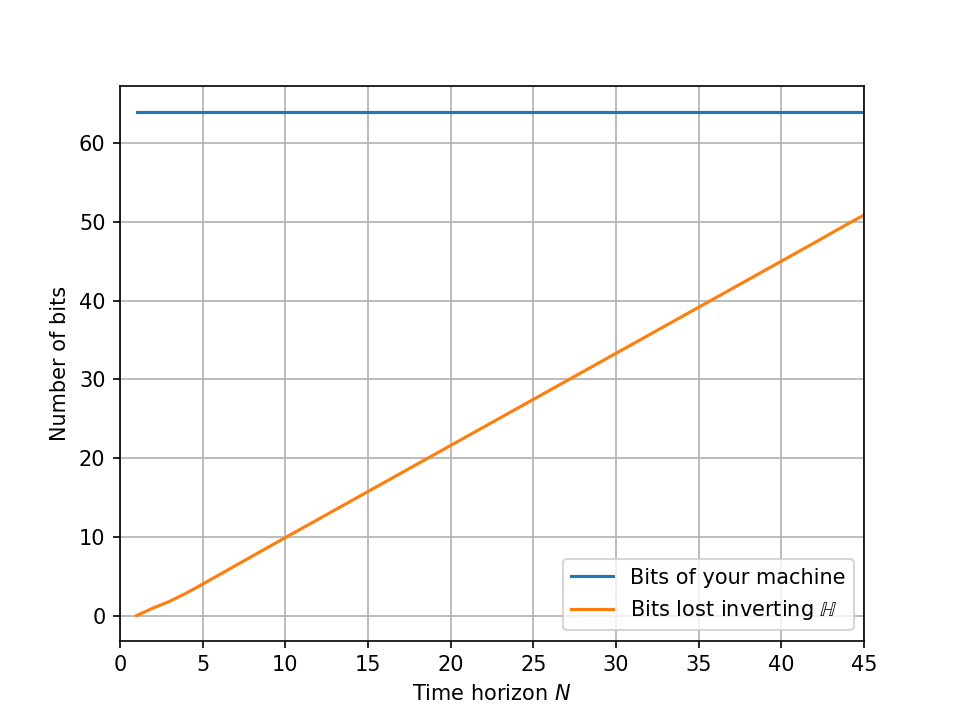

In [215]:
# plot the trend of the number of lost digits
def plot_lost_bits(lost_bits):
    
    # plot number of bits in your machine
    N_max = len(lost_bits)
    plt.plot(
        range(1, N_max + 1),
        [np.log2(sys.maxsize) + 1] * N_max, # extra bit due to the sign
        label='Bits of your machine'
    )
    
    # plot number of bits lost inverting Hb
    plt.plot(
        range(1, N_max + 1),
        lost_bits,
        label=r'Bits lost inverting $\mathbb{H}$'
    )
    
    # misc settings
    plt.xlim(0, N_max)
    plt.xlabel(r'Time horizon $N$')
    plt.ylabel(r'Number of bits')
    plt.grid(True)
    plt.legend()
    
# plot your results
plt.figure()
plot_lost_bits(lost_bits_shooting)

## Direct Transcription

Let's now give a try to the direct transcription approach.
In these setting, our LQR problem is a quadratic optimization problem with equality constraints (i.e. the system dynamics).
To solve it, we use the technique of the [Lagrange multipliers](https://en.wikipedia.org/wiki/Lagrange_multiplier).

We define the Lagrange multipliers $\lambda[0], \ldots, \lambda[N]$, and instead of enforcing the dynamics as constraints, we penalize it in the objective function.
To this end, we define the Lagrangian function
$$
L =
J +
\lambda^T[0] (\mathbf{x}_0 - \mathbf{x}[0]) +
\sum_{n=0}^{N-1}
\lambda^T[n+1](\mathbf{A} \mathbf{x}[n] + \mathbf{B} \mathbf{u}[n] - \mathbf{x}[n+1]).
$$

The optimal solution of the constrained optimization problem, is now recovered by minimizing the unconstrained Lagrangian function $L$ with respect to the states $\mathbf{x}[n]$, the controls $\mathbf{u}[n]$, and also the multipliers $\lambda[n]$.
This can be done by simply setting the derivative of $L$ with respect to these variables to zero.

Here are the resulting derivatives directly in matrix form.
If your eyes are trained in taking derivatives, you might quickly double-check this, if not, don't feel the need to derive this again...

<!--
At the optimum, the gradient of $L$ with respect to $\mathbf{x}[n]$, $\mathbf{u}[n]$, and $\lambda[n]$ must vanish.
We obtain the optimality conditions:
- $\nabla_{\lambda[0]} L = \mathbf{x}_0 - \mathbf{x}[0]$,
- $\nabla_{\lambda[n]} L = \mathbf{A} \mathbf{x}[n] + \mathbf{B} \mathbf{u}[n] - \mathbf{x}[n+1] = 0$ for $n = 1, \ldots, N$,
- $\nabla_{\mathbf{x}[n]} L = 2 \mathbf{Q} \mathbf{x}[n] - \lambda[n] + \mathbf{A}^T \lambda[n+1] = 0$ for $n = 0, \ldots, N-1$,
- $\nabla_{\mathbf{x}[N]} L = 2 \mathbf{Q} \mathbf{x}[N] - \lambda[N] = 0$,
- $\nabla_{\mathbf{u}[n]} L = 2 \mathbf{R} \mathbf{u}[n] + \mathbf{B}^T \lambda[n+1] = 0$ for $n = 0, \ldots, N-1$.
-->

$$
\begin{bmatrix}
\nabla_{\lambda[0]} L \\
\nabla_{\mathbf{x}[0]} L \\
\nabla_{\mathbf{u}[0]} L \\
\nabla_{\lambda[1]} L \\
\nabla_{\mathbf{x}[1]} L \\
\nabla_{\mathbf{u}[1]} L \\
\vdots \\
\nabla_{\mathbf{u}[N-1]} L \\
\nabla_{\lambda[N]} L \\
\nabla_{\mathbf{x}[N]} L \\
\end{bmatrix}
=
\begin{bmatrix}
0 & -\mathbf{I} & 0 & 0 & 0 & 0 & 0 & \cdots & 0 & 0 & 0 & 0 \\
-\mathbf{I} & 2 \mathbf{Q} & 0 & \mathbf{A}^T & 0 & 0 & 0 & \cdots & 0 & 0 & 0 & 0 \\
0 & 0 & 2 \mathbf{R} & \mathbf{B}^T & 0 & 0 & 0 & \cdots & 0 & 0 & 0 & 0 \\
0 & \mathbf{A} & \mathbf{B} & 0 & -\mathbf{I} & 0 & 0 & \cdots & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & -\mathbf{I} & 2 \mathbf{Q} & 0 & \mathbf{A}^T & \cdots & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 2 \mathbf{R} & \mathbf{B}^T & \cdots & 0 & 0 & 0 & 0 \\
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \ddots & \vdots & \vdots & \vdots & \vdots \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & \cdots & 0 & 2 \mathbf{R} & \mathbf{B}^T & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & \cdots & \mathbf{A} & \mathbf{B} & 0 & -\mathbf{I} \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & \cdots & 0 & 0 & -\mathbf{I} & 2 \mathbf{Q}_N \\
\end{bmatrix}
\begin{bmatrix}
\lambda[0] \\
\mathbf{x}[0] \\
\mathbf{u}[0] \\
\lambda[1] \\
\mathbf{x}[1] \\
\mathbf{u}[1] \\
\lambda[2] \\
\vdots \\
\mathbf{x}[N-1] \\
\mathbf{u}[N-1] \\
\lambda[N] \\
\mathbf{x}[N] \\
\end{bmatrix}
+
\begin{bmatrix}
\mathbf{x}_0 \\
0 \\
0 \\
0 \\
0 \\
0 \\
\vdots \\
0 \\
0 \\
0 \\
\end{bmatrix}
= 0.
$$

In the following, we will compactly refer to this big linear system as $\mathbb{M} \mathbb{z} = \mathbb{x}_0$.
Where $\mathbb{M}$ is the big matrix in the center, $\mathbb{z}$ are the states, the controls, and the multipliers, and $\mathbb{x}_0$ is the (negative) initial conditions concatenated with all the zeros.

**On the sparsity pattern of the matrix $\mathbb{M}$**

Take some seconds to analyze the structure of the matrix $\mathbb{M}$.

First note that the entries of this matrix are nonzero only nearby the diagonal (such a matrix is called "[band sparse matrix](https://en.wikipedia.org/wiki/Band_matrix)").
When a matrix is [sparse](https://en.wikipedia.org/wiki/Sparse_matrix), it's always a good idea to take advantage of that: knowing ahead of time where the nonzero entries of our matrix are can save a lot of redundant computations (mostly multiplications by zero).
In the following code, we will exploit this structure in the solution of the linear system $\mathbb{M} \mathbb{z} = \mathbb{x}_0$ by using [`scipy` sparse matrix package](https://docs.scipy.org/doc/scipy/reference/sparse.html).

In the next cell, you are asked to code the building block of the function we use to construct $\mathbb{M}$.
For a generic time step $t$, consider the three equations: $\nabla_{\mathbf{x}[t]} L = 0$, $\nabla_{\mathbf{u}[t]} L = 0$, and $\nabla_{\lambda[t+1]} L = 0$.
And note that these equations only depend on five variables: $\lambda[t]$, $\mathbf{x}[t]$, $\mathbf{u}[t]$, $\lambda[t+1]$, and $\mathbf{x}[t+1]$.
(To convince yourself, start by considering $t=0$.)

These three equations and five variables determine a precise block of the matrix $\mathbb{M}$ which is repeated $N-1$ times along the diagonal.
Write a function named `diagonal_block_Mb` which constructs this block taking as inputs:
- the linear system matrices $A$ and $B$,
- the running cost weights $Q$ and $R$,

To do this, use the `scipy` block matrix function [`scipy.sparse.bmat`](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.bmat.html).

In [216]:
# function that given the dynamical system matrices
# A and B, and the weights Q and R, returns the
# reapeated block on the diagonal of Mb
def Mb_diagonal_block(A, B, Q, R):
    
    # number of states and inputs of the linear dynamics
    p, q = B.shape
    
    # block matrix
    Ip = sp.sparse.eye(p) # modify here
    Iq = sp.sparse.eye(q) # modify here
    
    Zp = np.zeros((p,p))
    my_block = sp.sparse.bmat([ # modify here
        [ -Ip,  2*Q, None, A.transpose(), None], # modify here
        [None, None,  2*R, B.transpose(), None], # modify here
        [None,    A,    B, None,   -Ip]  # modify here
    ])
    
    return my_block

Now we fill the matrix $\mathbb{M}$ with the code you wrote.
We already took care of the first row (initial conditions) and the final row (terminal cost).
For the rest we just copy and paste the matrix you wrote along the diagonal of $\mathbb{M}$.

Here are two efficient functions to derive $\mathbb{M}$ and $\mathbb{x}_0$ in [sparse form](https://en.wikipedia.org/wiki/Sparse_matrix).

In [217]:
# efficient computation of the matrix Mb
# uses scipy sparse matrices:
# https://docs.scipy.org/doc/scipy/reference/sparse.html
def get_Mb(A, B, Q, R, QN, N):
    
    # number of states and inputs
    p, q = B.shape
    
    # number of optimization variables in zb
    n_zb = 2 * (N + 1) * p + N * q
    
    # initialize with empty sparse matrix
    # (lil stands for list of lists)
    Mb = sp.sparse.lil_matrix((n_zb, n_zb))
    
    # first block-row (initial conditions)
    Mb[:p, p:2*p] = - sp.sparse.eye(p)
    
    # use the function you wrote to get the diagonal block
    Mb_block = Mb_diagonal_block(A, B, Q, R)
    
    # initialize indices for the insertion of the blocks 
    rows = slice(p, Mb_block.shape[0] + p)
    cols = slice(0, Mb_block.shape[1])
    step = 2 * p + q
    
    # loop overt the diagonal and paste the Mb_block
    # in the appropriate spots
    for n in range(N):
        Mb[rows, cols] = Mb_block
        rows = slice(rows.start + step, rows.stop + step)
        cols = slice(cols.start + step, cols.stop + step)

    # last block-row (terminal state)
    Mb[-p:, -2*p:-p] = - sp.sparse.eye(p)
    Mb[-p:, -p:] = 2 * QN
    
    # convert matrix to scipy sparse csc matrix
    # (csc stands for compressed sparse column)
    return Mb.tocsc()

# efficient computation of the vector xb0
# p is the number of system states and
# p is the number of system inputs
def get_xb0(x0, p, q, N):
    
    # indices of the nonzero elements in xb0
    rows = range(p)
    cols = [0] * p
    sparsity = (rows, cols)
    
    # overall shape of xb0
    # (total number of rows, number of cols = 1)
    n_zb = 2 * (N + 1) * p + N * q
    shape = (n_zb, 1)
    
    # xb0 in sparse form
    xb0 = sp.sparse.csc_matrix((x0, sparsity), shape=shape)
    
    return xb0

Here is a nice `matplotlib` function that allows you to "spy" inside a matrix and look at its structure (a.k.a. the sparsity pattern).

<IPython.core.display.Javascript object>


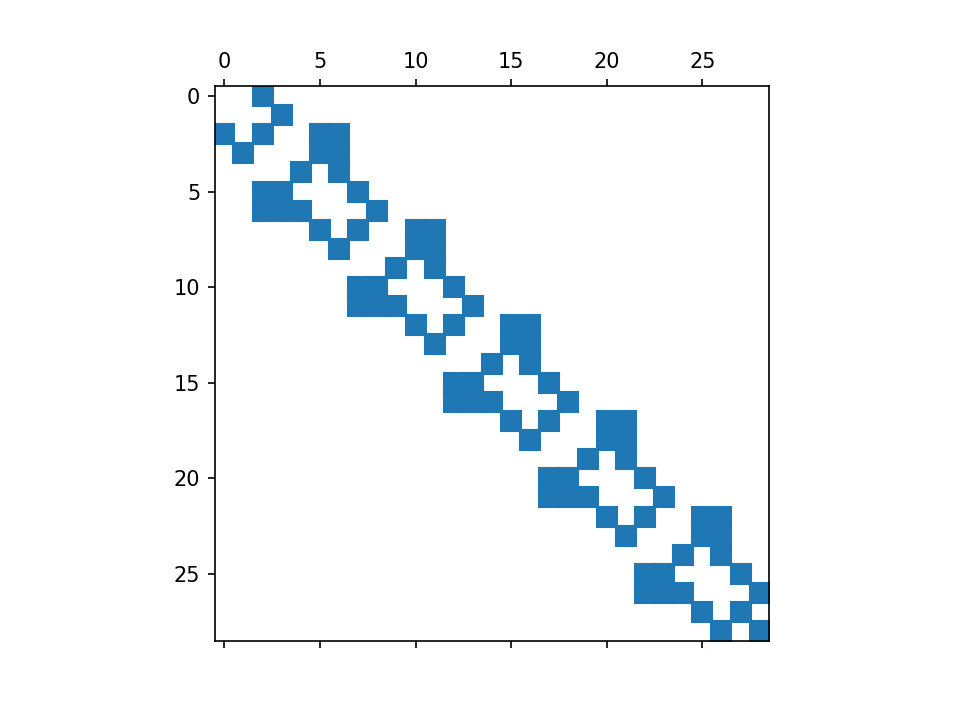

In [218]:
# arbitrary short time horizon
N = 5

# plot the sparsity pattern of Mb
plt.figure()
plt.spy(get_Mb(A, B, Q, R, QN, N))

To simplify your upcoming work, we provided you:
- Two functions to extract the states $\mathbb{x}$ and the controls $\mathbb{u}$ from the unknowns $\mathbb{z}$ of the linear system $\mathbb{M} \mathbb{z} = \mathbb{x}_0$.
- A function to evaluate $J$ given $\mathbb{x}$ and $\mathbb{u}$.

In [219]:
# function that extracts the vector
# xb = (x[0], ..., x[N]) from zb
def extract_xb_from_zb(zb, p, q, N):
    
    # index of the first element of x[0] in the vector zb
    start = p
    
    # distance between x[n] and x[n+1] in the vector zb
    step = 2 * p + q
    
    # extract states
    xb_indices = [start + step * n + i for n in range(N+1) for i in range(p)]
    xb = zb[xb_indices]
    
    return xb

# function that extracts the vector
# ub = (u[0], ..., u[N-1]) from zb
def extract_ub_from_zb(zb, p, q, N):
    
    # index of the first element of u[0] in the vector zb
    start = 2 * p
    
    # distance between u[n] and u[n+1] in the vector zb
    step = 2 * p + q
    
    # extract controls
    ub_indices = [start + step * n + i for n in range(N) for i in range(q)]
    ub = zb[ub_indices]

    return ub

# function that evaluates the objective J
# given the block vectors xb and ub
def evaluate_J(xb, ub, Q, R, QN, N):
    
    # block diagonal cost matrices
    # (Qb has one extra block for the initial state here)
    Qb = sp.sparse.block_diag(([Q] * N + [QN]))
    Rb = sp.sparse.block_diag(([R] * N))
    
    # compute value function
    J = xb.dot(Qb.dot(xb)) + ub.dot(Rb.dot(ub))
    
    return J

Now it's your turn again.
For direct shooting, we have defined above the function `get_J_star_N_shooting(A, B, Q, R, QN, N, x0)`, which given the LQR data and the initial state, returns the cost to go for the finite-horizon problem using direct shooting.

In the following cell you're asked to write the analogous function for the direct transcription method.
The function must have the name `get_J_star_N_transcription` and its arguments must be `A, B, Q, R, QN, N, x0`.
The steps in this function must be:
- get the matrix $\mathbb{M}$ and the vector $\mathbb{x}_0$,
- solve the linear system $\mathbb{M} \mathbb{z} = \mathbb{x}_0$ for $\mathbb{z}^*$,
- extract $\mathbb{x}^*$ and $\mathbb{u}^*$ from $\mathbb{z}^*$,
- plug $\mathbb{x}^*$ and $\mathbb{u}^*$ in the expression for $J$.

To solve the sparse linear system $\mathbb{M} \mathbb{z} = \mathbb{x}_0$, use the `scipy` function [`scipy.sparse.linalg.spsolve`](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.linalg.spsolve.html), which is already imported as `spsolve`.

In [220]:
# function that given the system state x0 (together with:
# the dynamical system matrices A, B; the objective weights
# Q, R, QN; and the controller horizon N) returns the cost
# to go of the finite-horizon LQR using direct transcription
def get_J_star_N_transcription(A, B, Q, R, QN, N, x0):
    p, q = B.shape
    Mb = get_Mb(A, B, Q, R, QN, N)
    xb0 = get_xb0(x0, p, q, N)
    zb = spsolve(Mb,xb0)
    xb = extract_xb_from_zb(zb, p, q, N)
    ub = extract_ub_from_zb(zb, p, q, N)
    return evaluate_J(xb, ub, Q, R, QN, N) # modify here

Here is the same plot we had for direct shooting, for a longer maximum horizon `N_max = 100`. Does it look better than the direct-shooting one?

<IPython.core.display.Javascript object>


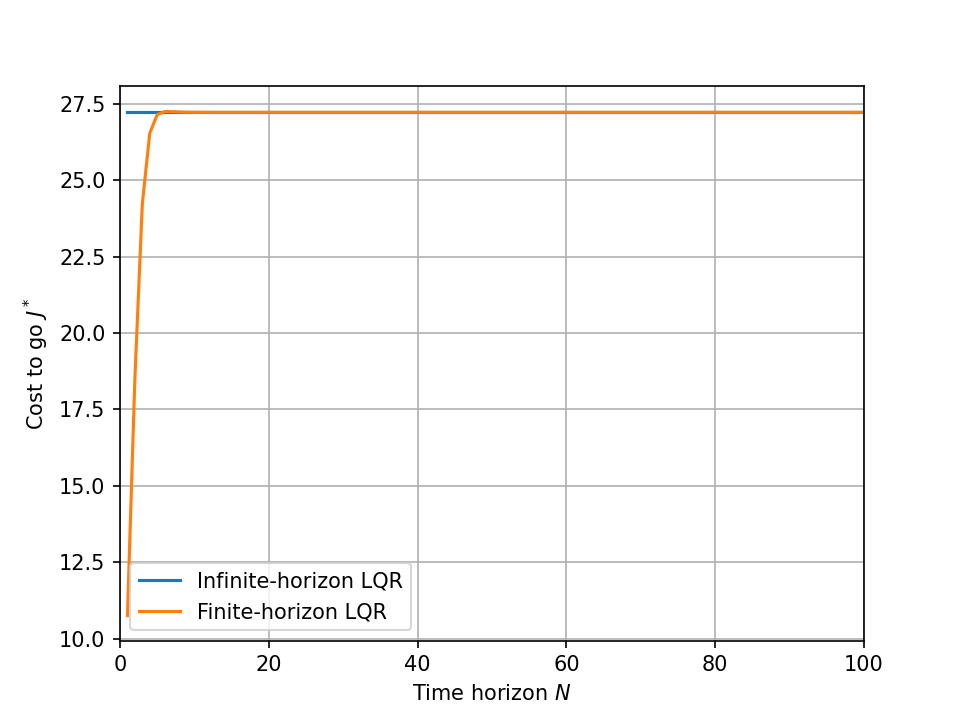

In [221]:
# get cost to go as a function of N
N_max = 100
J_star_N_transcription = [get_J_star_N_transcription(A, B, Q, R, QN, N, x0) for N in range(1, N_max + 1)]

# plot finite horizon vs infinite horizon
plt.figure()
plot_J_star(J_star_N_transcription, J_star_inf)

It's time to replicate the plot of the lost digits in the case of direct transcription.
Now we look at the condition number of $\mathbb{M}$.

Define a list with name `lost_bits_transcription` which contains `N_max = 100` elements.
For `N` ranging from `1` to `N_max`, the `N`th entry in `lost_bits_transcription` must be logarithm in base 2 of the condition number of $\mathbb{M}$ (`Mb` in the code) for a time horizon equal to `N`.
Note that, in order to use the function [`numpy.linalg.cond`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.cond.html), you first need to convert `Mb` to be a dense matrix.
This can be done as `Mb_dense = Mb.todense()`.

In [222]:
# number of bits lost in the inversion of Mb
# as a function of the time horizon N

def calc_cond_for_N(N):
    Mb = get_Mb(A, B, Q, R, QN, N)
    Mb_dense = Mb.todense()
    return np.linalg.cond(Mb_dense)

lost_bits_transcription = [np.log2(calc_cond_for_N(N)) for N in range(1, N_max + 1)] # modify here

Does this plot look better than the direct-shooting one?
Which kind of law does this curve follow: constant, logarithmic, linear, polynomial, or exponential?

<IPython.core.display.Javascript object>


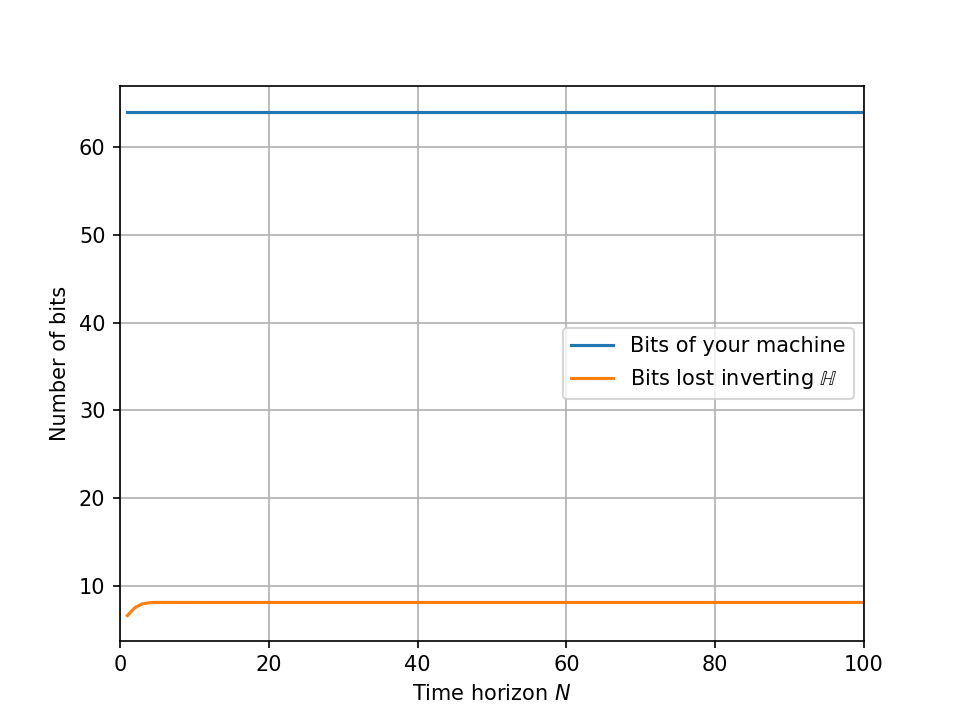

In [223]:
# plot your results
plt.figure()
plot_lost_bits(lost_bits_transcription)

## Dynamic Programming Recursion, a.k.a. Riccati Recursion

Even if we did our best to exploit the sparsity in the linear system of the direct transcription method, this approach was still quite slow.
It turns out that the particular structure of the matrix $\mathbb{M}$ can be exploited even more and the linear system $\mathbb{M} \mathbb{z} = \mathbb{x}_0$ can be solved much faster.

The name of the technique to do this is "Riccati recursion."
You can find more details in [this paper](https://link.springer.com/article/10.1023/A:1021711402723) or in [these lecture notes](https://web.stanford.edu/class/ee363/notes/riccati-derivation.pdf).
(The second should be an easier read.)
The main idea is to invert the matrix $\mathbb{M}$ one block per time, starting from the bottom right, and moving up; in a similar spirit of dynamics programming.

This idea has had a big impact in robotics, allowing the solution of optimal control problems in real time.
Researchers from ETH Zurich have done an amazing job at pushing techniques like this to the limit (see, for example, [this paper](https://arxiv.org/pdf/1710.04029.pdf)).
Here is their quadruped robot ANYmal.
Its control software takes great advantage of techniques like the ones we studied in this notebook.

In [224]:
from IPython.display import IFrame
IFrame(src='https://www.youtube.com/embed/m1-s8iOJaI4', width='640', height='360')

The Riccati recursion idea can be applied very broadly; all the way to nonlinear constrained optimization.
However, in our simple settings, it can be seen that it is equivalent to the dynamic programming recursion [which we have seen in class](http://underactuated.mit.edu/lqr.html#dt_riccati).
Have a look at [these lecture notes](https://web.stanford.edu/class/ee363/notes/riccati-derivation.pdf) if you want to convince yourself about this equivalence.

We initialize $n = N$ and the cost-to-go matrix $\mathbf{S}[N] = \mathbf{Q}_N$.
Then we go backwards in time computing
$$
\mathbf{S}[n-1] =
\mathbf{Q} +
\mathbf{A}^T\mathbf{S}[n]\mathbf{A} -
\mathbf{A}^T\mathbf{S}[n]\mathbf{B}
(\mathbf{R} + \mathbf{B}^T\mathbf{S}[n]\mathbf{B})^{-1}
\mathbf{B}^T\mathbf{S}[n]\mathbf{A}
$$
until we get $\mathbf{S}[0]$.

This is the last piece of code you are asked to write.
A function called `riccati_recursion` which takes as inputs `(A, B, Q, R, QN, N)` and returns the optimal cost-to-go matrix $\mathbf{S}[0]$ for the finite-horizon LQR with $N$ steps.
Do this by implementing the recursion above.

In [225]:
# implementation of the Riccati recursion
def riccati_recursion(A, B, Q, R, QN, N):
    S = QN
 
    At = A.transpose()
    Bt = B.transpose()
    #print(mm)
    #print((B.transpose()*S*B).shape)
    for n in range(N):
        S = Q + At.dot(S).dot(A) - At.dot(S).dot(B).dot(np.linalg.inv(R+Bt.dot(S).dot(B))).dot(Bt).dot(S).dot(A) # modify here
    return S

Here is the same old plot of finite-horizon LQR vs infinite-horizon LQR.
If you have done things correctly, this should be super fast and numerically very stable.
We push the maximum time horizon `N_max` all the way to `1000` here.

<IPython.core.display.Javascript object>


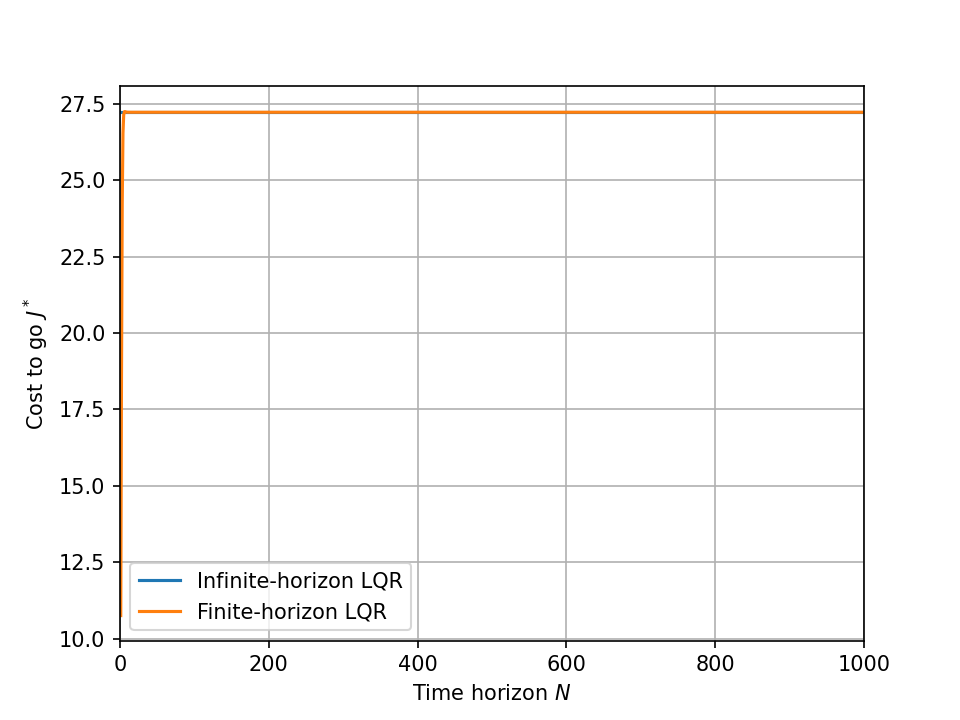

In [226]:
# implementation of the Riccati recursion
# function that given the system state x0 (together with:
# the dynamical system matrices A, B; the objective weights
# Q, R, QN; and the controller horizon N) returns the cost
# to go of the finite-horizon LQR
def get_J_star_N_riccati(A, B, Q, R, QN, N, x0):
    S = riccati_recursion(A, B, Q, R, QN, N)
    return x0.dot(S).dot(x0)

# get cost to go as a function of N
N_max = 1000
J_star_N_riccati = [get_J_star_N_riccati(A, B, Q, R, QN, N, x0) for N in range(1, N_max + 1)]

# plot finite horizon vs infinite horizon
plt.figure()
plot_J_star(J_star_N_riccati, J_star_inf)

## Take-Home Messages

Summarizing the main lessons of the notebook:
- Linear algebra can be tedious, but is a fundamental issue in trajectory optimization.
- Direct transcription leads to bigger optimization problems than direct shooting, but these are better conditioned and can be solved very fast using specialized techniques (Riccati recursion).

## Autograding
You can check your work by running the following cell.

In [227]:
from underactuated.exercises.trajopt.shooting_vs_transcription.test_shooting_vs_transcription import TestShootingVsTranscription
from underactuated.exercises.grader import Grader
Grader.grade_output([TestShootingVsTranscription], [locals()], 'results.json')
Grader.print_test_results('results.json')

Total score is 18/18.

Score for Test value function Riccati recursion is 4/4.

Score for Test value function direct transcription is 4/4.

Score for Test construction of diagonal block of Mb is 4/4.

Score for Test number of bits lost with direct shooting is 3/3.

Score for Test number of bits lost with direct transcription is 3/3.
